<a href="https://colab.research.google.com/github/Zhangyuyi-0825/FI-SHAP/blob/main/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 4.4 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context={'axes.labelsize':18,
                                'xtick.labelsize':15,
                                'ytick.labelsize':15})
import warnings
warnings.filterwarnings('ignore')

import datetime as dt
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
import catboost as cab
from catboost import CatBoostRegressor
import shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gen_1=pd.read_csv('drive/My Drive/Solar_Power_data/Plant_1_Generation_Data.csv')
gen_1.drop('PLANT_ID',1,inplace=True)
sens_1= pd.read_csv('drive/My Drive/Solar_Power_data/Plant_1_Weather_Sensor_Data.csv')
sens_1.drop('PLANT_ID',1,inplace=True)
sens_1.drop('SOURCE_KEY',1,inplace=True)

In [ ]:
gen_2=pd.read_csv('drive/My Drive/Solar_Power_data/Plant_2_Generation_Data.csv')
gen_2.drop('PLANT_ID',1,inplace=True)
sens_2= pd.read_csv('drive/My Drive/Solar_Power_data/Plant_2_Weather_Sensor_Data.csv')
sens_2.drop('PLANT_ID',1,inplace=True)
sens_2.drop('SOURCE_KEY',1,inplace=True)

In [ ]:
#format datetime
gen_1['DATE_TIME']= pd.to_datetime(gen_1['DATE_TIME'],format='%d-%m-%Y %H:%M')
sens_1['DATE_TIME']= pd.to_datetime(sens_1['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

In [ ]:
#format datetime
gen_2['DATE_TIME']= pd.to_datetime(gen_2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
sens_2['DATE_TIME']= pd.to_datetime(sens_2['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

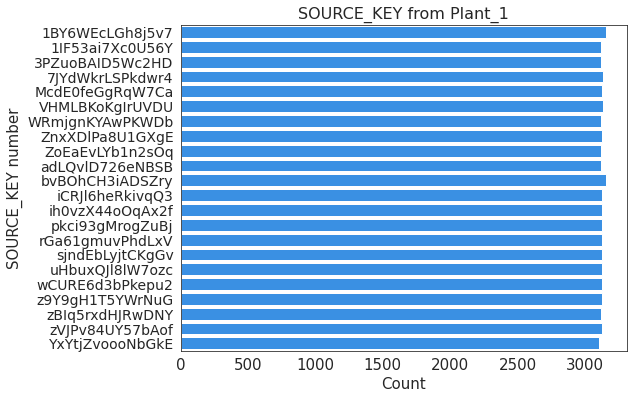

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plot = sns.countplot(y="SOURCE_KEY", data=gen_1, palette=['dodgerblue']).set_title('SOURCE_KEY from Plant_1', fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Count", fontsize=15)
plt.ylabel("SOURCE_KEY number", fontsize=15)
plt.show(plot)

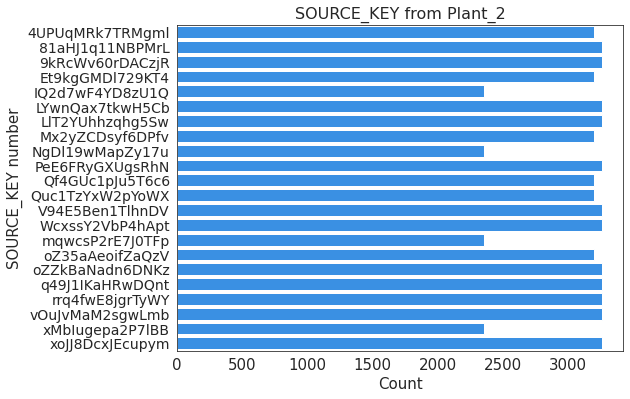

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plot = sns.countplot(y="SOURCE_KEY", data=gen_2, palette=['dodgerblue']).set_title('SOURCE_KEY from Plant_2', fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Count", fontsize=15)
plt.ylabel("SOURCE_KEY number", fontsize=15)
plt.show(plot)

## Splite dataframe based on source_key

In [ ]:
print(list(set(gen_1['SOURCE_KEY'])))

['7JYdWkrLSPkdwr4', 'YxYtjZvoooNbGkE', 'bvBOhCH3iADSZry', 'zBIq5rxdHJRwDNY', '3PZuoBAID5Wc2HD', 'pkci93gMrogZuBj', 'McdE0feGgRqW7Ca', 'zVJPv84UY57bAof', 'iCRJl6heRkivqQ3', 'z9Y9gH1T5YWrNuG', '1IF53ai7Xc0U56Y', 'WRmjgnKYAwPKWDb', '1BY6WEcLGh8j5v7', 'VHMLBKoKgIrUVDU', 'ZoEaEvLYb1n2sOq', 'uHbuxQJl8lW7ozc', 'wCURE6d3bPkepu2', 'ZnxXDlPa8U1GXgE', 'sjndEbLyjtCKgGv', 'rGa61gmuvPhdLxV', 'adLQvlD726eNBSB', 'ih0vzX44oOqAx2f']


In [ ]:
#固定字表格的顺序
source_key_1 = ['zBIq5rxdHJRwDNY','WRmjgnKYAwPKWDb','VHMLBKoKgIrUVDU','rGa61gmuvPhdLxV',
                'zVJPv84UY57bAof','1BY6WEcLGh8j5v7','sjndEbLyjtCKgGv','7JYdWkrLSPkdwr4',
                '1IF53ai7Xc0U56Y','pkci93gMrogZuBj','uHbuxQJl8lW7ozc','YxYtjZvoooNbGkE',
                'ZnxXDlPa8U1GXgE','ZoEaEvLYb1n2sOq','z9Y9gH1T5YWrNuG','wCURE6d3bPkepu2',
                'bvBOhCH3iADSZry','iCRJl6heRkivqQ3','McdE0feGgRqW7Ca','adLQvlD726eNBSB',
                'ih0vzX44oOqAx2f','3PZuoBAID5Wc2HD']

In [ ]:
len(source_key_1)

22

In [ ]:
print(list(set(gen_2['SOURCE_KEY'])))

['WcxssY2VbP4hApt', 'oZZkBaNadn6DNKz', 'V94E5Ben1TlhnDV', 'NgDl19wMapZy17u', 'LlT2YUhhzqhg5Sw', 'q49J1IKaHRwDQnt', '9kRcWv60rDACzjR', 'vOuJvMaM2sgwLmb', 'LYwnQax7tkwH5Cb', 'Et9kgGMDl729KT4', 'xoJJ8DcxJEcupym', 'IQ2d7wF4YD8zU1Q', 'mqwcsP2rE7J0TFp', 'PeE6FRyGXUgsRhN', '4UPUqMRk7TRMgml', '81aHJ1q11NBPMrL', 'Quc1TzYxW2pYoWX', 'Qf4GUc1pJu5T6c6', 'Mx2yZCDsyf6DPfv', 'oZ35aAeoifZaQzV', 'rrq4fwE8jgrTyWY', 'xMbIugepa2P7lBB']


In [ ]:
#固定字表格的顺序
source_key_2 = ['PeE6FRyGXUgsRhN', 'Qf4GUc1pJu5T6c6', 'Et9kgGMDl729KT4', 'oZZkBaNadn6DNKz', 
                '81aHJ1q11NBPMrL', 'xMbIugepa2P7lBB', 'IQ2d7wF4YD8zU1Q', 'oZ35aAeoifZaQzV', 
                'Mx2yZCDsyf6DPfv', 'q49J1IKaHRwDQnt', 'V94E5Ben1TlhnDV', 'Quc1TzYxW2pYoWX', 
                'LlT2YUhhzqhg5Sw', 'WcxssY2VbP4hApt', 'rrq4fwE8jgrTyWY', 'xoJJ8DcxJEcupym', 
                '4UPUqMRk7TRMgml', 'vOuJvMaM2sgwLmb', '9kRcWv60rDACzjR', 'NgDl19wMapZy17u', 
                'LYwnQax7tkwH5Cb', 'mqwcsP2rE7J0TFp']

In [ ]:
#创建足够的表格类的变量名
def build_df_name(source_key_list,name):
    createDataframe = locals()
    dataframeList = []
    for i in range(0,len(source_key_list)):
        createDataframe[name + str(i)] = 'df' + name + str(i)
        dataframeList.append(createDataframe[name + str(i)])
    return dataframeList

#按照制定的特征，拆分表格
def build_df(orig_dataset, source_key_list, feature_name):
    
    name_list = build_df_name(source_key_list, feature_name)
    
    for n in range(0, len(name_list)):
        name_list[n] = pd.DataFrame()
        name_list[n] = orig_dataset[orig_dataset[feature_name] == source_key_list[n]]
        name_list[n].drop(feature_name,1,inplace=True)
        
    return name_list

In [ ]:
df1 = build_df(gen_1, source_key_1, 'SOURCE_KEY')

In [ ]:
df2 = build_df(gen_2, source_key_2,'SOURCE_KEY')

In [ ]:
def mergeDataframe(set_df, add_dataset, feature_name):
    for i in range(0,len(set_df)):
        set_df[i] = pd.merge(set_df[i],add_dataset,how = 'outer',on = [feature_name])
        set_df[i] = set_df[i].dropna(axis = 0, how = 'any')
        
        set_df[i]['Year'] = pd.to_datetime(set_df[i]['DATE_TIME']).dt.year
        set_df[i]['Month'] = pd.to_datetime(set_df[i]['DATE_TIME']).dt.month
        set_df[i]['Day'] = pd.to_datetime(set_df[i]['DATE_TIME']).dt.day
        set_df[i]['Hour'] = pd.to_datetime(set_df[i]['DATE_TIME']).dt.hour
        set_df[i]['Minute'] = pd.to_datetime(set_df[i]['DATE_TIME']).dt.minute
        
    return set_df

In [ ]:
df1 = mergeDataframe(df1, sens_1, 'DATE_TIME')

In [ ]:
df2 = mergeDataframe(df2, sens_2, 'DATE_TIME')

In [ ]:
def xgboost_results(set_df):
    acc = []
    rmse = []
    
    for i in range(0, len(set_df)):

        train_set = set_df[i][set_df[i]['DATE_TIME']<'2020-06-09 00:00']
        test_set  = set_df[i][set_df[i]['DATE_TIME']>='2020-06-09 00:00']
        
        x_train = train_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_train = train_set.loc[:,['DAILY_YIELD']]
        x_test = test_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_test = test_set.loc[:,['DAILY_YIELD']]
        
        model_xgb = XGBRegressor()
        
        model_xgb.fit(
            x_train, 
            y_train, 
            eval_metric="rmse", 
            eval_set=[(x_train, y_train),(x_test,y_test)], 
            verbose=False, 
            early_stopping_rounds = 100)
        
        prediction = model_xgb.predict(x_test)
        r2 = r2_score(y_test,prediction)
        RMSE = np.sqrt(mean_squared_error(y_test,prediction))
            
        acc.append(r2)
        rmse.append(RMSE)
    
    return acc, rmse 

In [ ]:
xgb_results_plant1 = xgboost_results(df1)

[17:53:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
def sort_and_index(list_name):
    max_index = list_name.index(max(list_name))
    min_index = list_name.index(min(list_name))
    
    max_values = float(list_name[max_index])
    min_values = float(list_name[min_index])
    
    return print("max is: ",max_values,"index is: ",max_index," ; ","min is: ",min_values,"index is: ",min_index)

In [ ]:
xgb_plant1_accuracy = xgb_results_plant1[0]
print(xgb_plant1_accuracy)

[0.9345738662158236, 0.9402650545623475, 0.9425666864522146, 0.9345480215665836, 0.9382476169423307, 0.9200979039142184, 0.9382144109673068, 0.9416750357872062, 0.9356686073857605, 0.9401023805329111, 0.9416089762575034, 0.9418205448497432, 0.9450682036048136, 0.940364347251895, 0.9450941153683446, 0.9360525052583593, 0.916373653399446, 0.9340062412886068, 0.9421890962142222, 0.9347601180036086, 0.94454896770315, 0.9322539580993406]


In [ ]:
sort_and_index(xgb_plant1_accuracy)

max is:  0.9450941153683446 index is:  14  ;  min is:  0.916373653399446 index is:  16


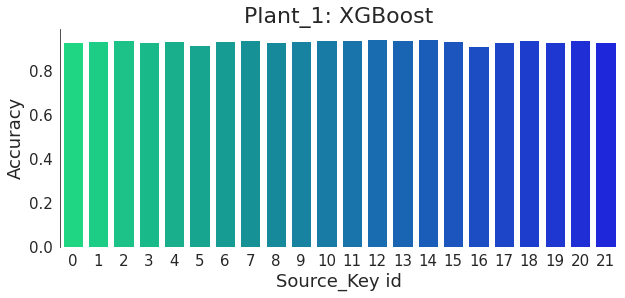

In [ ]:
fig = plt.figure(figsize=(10,4))

x = list(range(22))
y = xgb_plant1_accuracy


sns.barplot(x,y, palette="winter_r")
sns.despine(bottom=True)

plt.title('Plant_1: XGBoost', fontsize = 22)
plt.xlabel('Source_Key id', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)

plt.show()

In [ ]:
xgb_plant1_rmse = xgb_results_plant1[1]
print(xgb_plant1_rmse)

[758.804291548878, 729.5341131251247, 725.8066514580163, 768.9985543202192, 749.5339296847399, 758.1877392412073, 740.9928731828675, 713.7077184485039, 773.1511240010899, 735.4683669145829, 732.1558959261293, 714.7027373818684, 704.1441885109773, 723.0391201653135, 687.1992336302227, 752.1608422569083, 763.1207388608697, 776.8902983925323, 729.9945326064224, 787.4657791386807, 686.368918592655, 792.6370679194765]


In [ ]:
xgb_results_plant2 = xgboost_results(df2)

[17:53:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
xgb_plant2_accuracy = xgb_results_plant2[0]
print(xgb_plant2_accuracy)

[0.13246222981715838, 0.1417346304428755, 0.36505784464878266, 0.810793643585558, 0.878671312043763, 0.5351767125125982, 0.10267006715824378, 0.2978015274007568, 0.12431993405928221, 0.36725808383603, 0.7551165039850507, 0.2715485564067228, 0.4153725116119814, 0.1763673164406825, 0.25149492750620817, 0.13462460828945122, 0.0932033740339876, 0.051236121433668735, 0.6898583241408892, 0.17336029835582012, -0.011529407648478207, 0.8139066876146093]


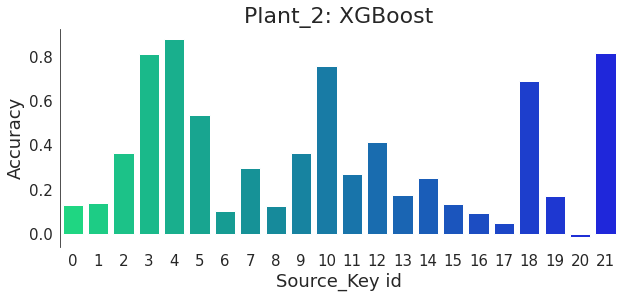

In [ ]:
fig = plt.figure(figsize=(10,4))

x = list(range(22))
y = xgb_plant2_accuracy


sns.barplot(x,y, palette="winter_r")
sns.despine(bottom=True)

plt.title('Plant_2: XGBoost', fontsize = 22)
plt.xlabel('Source_Key id', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)

plt.show()

In [ ]:
xgb_plant2_rmse = xgb_results_plant2[1]
print(xgb_plant2_rmse)

[2196.1093082181296, 2219.432273559208, 1310.6829360933407, 1021.5360131613968, 862.0568793677497, 1717.8848605540134, 2417.0878153196195, 1826.9203732193412, 2208.0983703839006, 1801.2175981736327, 1071.1666770356856, 1385.2247440829528, 1658.642914576919, 2068.341620810241, 1792.9448982481615, 2255.5882533044164, 2359.8668037553, 2559.3591497546986, 1231.071965667487, 2233.3040293891872, 2189.3493445365566, 1067.9382440909872]


In [ ]:
def lightgbm_results(set_df):
    acc = []
    rmse = []
    
    for i in range(0, len(set_df)):
        train_set = set_df[i][set_df[i]['DATE_TIME']<'2020-06-09 00:00']
        test_set  = set_df[i][set_df[i]['DATE_TIME']>='2020-06-09 00:00']
        
        x_train = train_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_train = train_set.loc[:,['DAILY_YIELD']]
        x_test = test_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_test = test_set.loc[:,['DAILY_YIELD']]
        
        model_lgb = lgb.LGBMRegressor()
        
        model_lgb.fit(x_train, y_train,eval_metric="rmse", 
                            eval_set=[(x_train, y_train)], 
                            verbose=False, 
                            early_stopping_rounds = 100)
        
        prediction = model_lgb.predict(x_test)
        r2 = r2_score(y_test,prediction)
        RMSE = np.sqrt(mean_squared_error(y_test,prediction))
            
        acc.append(r2)
        rmse.append(RMSE)
    
    return acc, rmse 

In [ ]:
lgb_results_plant1 = lightgbm_results(df1)

In [ ]:
lgb_plant1_accuracy = lgb_results_plant1[0]
print(lgb_plant1_accuracy)

[0.8920914963125419, 0.8365176750967442, 0.8560506338698766, 0.9143302356707242, 0.914597088343345, 0.7609665991766066, 0.919488463511271, 0.8677258910571021, 0.8310167551201637, 0.9132750393414173, 0.9202611675550683, 0.9126459612049036, 0.8577244741019465, 0.9143457989531297, 0.9391447973584179, 0.9093479555633973, 0.7793245627660363, 0.9141643667087964, 0.9237473411169519, 0.8389461652119309, 0.8641909313438149, 0.8383324040787631]


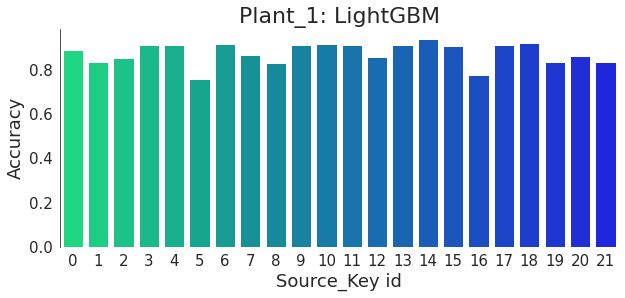

In [ ]:
fig = plt.figure(figsize=(10,4))

x = list(range(22))
y = lgb_plant1_accuracy


sns.barplot(x,y, palette="winter_r")
sns.despine(bottom=True)

plt.title('Plant_1: LightGBM', fontsize = 22)
plt.xlabel('Source_Key id', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)

plt.show()

In [ ]:
lgb_plant1_rmse = lgb_results_plant1[1]
print(lgb_plant1_rmse)

[974.5003175855528, 1206.8874502546043, 1149.0631195651054, 879.7877692276581, 881.4562772044353, 1311.3751995385223, 845.8619567920732, 1074.8072204181842, 1253.0682839444526, 884.9755508784716, 855.5895181721188, 875.753971016557, 1133.2214808995666, 866.5290785723632, 723.4725809732516, 895.5457026293755, 1239.6488792307807, 886.0170386066113, 838.382537446783, 1237.2590563270476, 1074.1555493799567, 1224.458034554164]


In [ ]:
lgb_results_plant2 = lightgbm_results(df2)

In [ ]:
lgb_plant2_accuracy = lgb_results_plant2[0]
print(lgb_plant2_accuracy)

[-0.47280282746920843, -0.9627059597426135, 0.502347628265477, -0.4866876477858544, -0.045213398171449315, -0.17671487766209948, -0.29289578635454583, -0.10793473852774516, -1.0735338469907068, 0.18898112697315106, -0.5469759062824087, 0.2887752615081761, -0.13487379710216296, 0.15573326729609427, 0.40781955060918407, -0.6286200408460278, -0.9557401812155635, -0.14816632439752153, 0.6534978277940677, -0.48766516237522217, 0.04995397953884484, 0.20276947793047595]


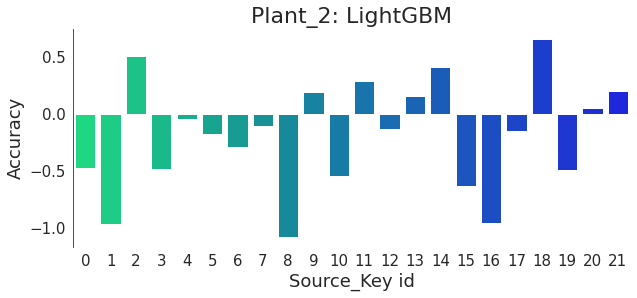

In [ ]:
fig = plt.figure(figsize=(10,4))

x = list(range(22))
y = lgb_plant2_accuracy


sns.barplot(x,y, palette="winter_r")
sns.despine(bottom=True)

plt.title('Plant_2: LightGBM', fontsize = 22)
plt.xlabel('Source_Key id', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)

plt.show()

In [ ]:
lgb_plant2_accuracy = lgb_results_plant2[1]
print(lgb_plant2_accuracy)

[2861.422985071653, 3356.284156963731, 1160.362282086906, 2863.4901076804717, 2530.210510308321, 2733.290145613035, 2901.3365663041877, 2294.810183725969, 3397.826897397729, 2039.2400835797573, 2692.2728414499206, 1368.7475779281785, 2310.9314684278083, 2094.089907059524, 1594.7646539954264, 3094.3357928171913, 3465.677306852332, 2815.4937355530565, 1301.236861998557, 2996.0034984955882, 2121.769149148041, 2210.409380403446]


In [ ]:
#def catboost_results(set_df):
    acc = []
    rmse = []
    
    for i in range(0, len(set_df)):
        train_set = set_df[i][set_df[i]['DATE_TIME']<'2020-06-09 00:00']
        test_set  = set_df[i][set_df[i]['DATE_TIME']>='2020-06-09 00:00']
        
        x_train = train_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_train = train_set.loc[:,['DAILY_YIELD']]
        x_test = test_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_test = test_set.loc[:,['DAILY_YIELD']]
        
        model_cat = CatBoostRegressor(eval_metric='RMSE')

        model_cat.fit(x_train, y_train, 
                        eval_set=[(x_train, y_train)], 
                        verbose=False, 
                        early_stopping_rounds = 100)
        
        prediction = model_cat.predict(x_test)
        r2 = r2_score(y_test,prediction)
        RMSE = np.sqrt(mean_squared_error(y_test,prediction))
            
        acc.append(r2)
        rmse.append(RMSE)
    
    return acc, rmse  

In [ ]:
cat_results_plant1 = catboost_results(df1)

In [ ]:
cat_plant1_accuracy = cat_results_plant1[0]
print(cat_plant1_accuracy)

[0.8967409998786591, 0.9085252274323926, 0.909201069378934, 0.9064147596179499, 0.9075184210047886, 0.80424073840842, 0.8915287712992903, 0.9089240715590452, 0.901183438261499, 0.9057465459315863, 0.9063008411325035, 0.8989143993894777, 0.9114952185576215, 0.9024465245348556, 0.923522156108377, 0.8888857006892281, 0.8107228242940575, 0.8996527572178354, 0.8985655735329466, 0.892842578811181, 0.9057908718825358, 0.8904356076851634]


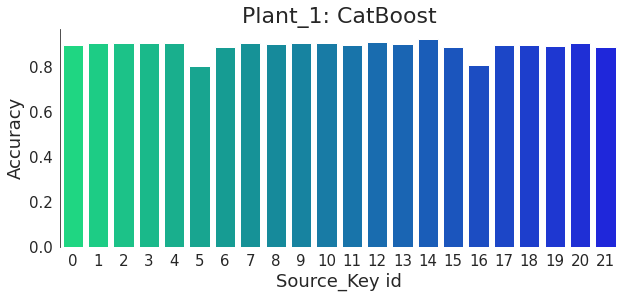

In [ ]:
fig = plt.figure(figsize=(10,4))

x = list(range(22))
y = cat_plant1_accuracy


sns.barplot(x,y, palette="winter_r")
sns.despine(bottom=True)

plt.title('Plant_1: CatBoost', fontsize = 22)
plt.xlabel('Source_Key id', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)

plt.show()

In [ ]:
cat_plant1_rmse = cat_results_plant1[1]
print(cat_plant1_rmse)

[953.2747888834972, 902.7802258667181, 912.5977089111796, 919.5340468569556, 917.2591532752654, 1186.7488785884727, 981.8105966395449, 891.856448091834, 958.2256336328193, 922.5881119737429, 927.4667850190499, 942.0745434433104, 893.7850074375491, 924.7624354085222, 811.0376914057357, 991.4799328580106, 1148.0764742935726, 957.9900267520849, 966.9575682494359, 1009.2208937831526, 894.6420010098567, 1008.0153193102046]


In [ ]:
cat_results_plant2 = catboost_results(df2)

In [ ]:
cat_plant2_accuracy = cat_results_plant2[0]
print(cat_plant2_accuracy)

[-0.25816835377666436, -0.5377432607987955, 0.43831724503566416, 0.172654149653804, 0.41404565400203597, -0.09159405170824764, -0.08371155661474128, 0.23255941782267486, -0.5462591237635057, 0.4311639177283896, -0.46613868541597947, 0.30380953443010683, 0.2508646318196779, 0.33552777489480246, 0.36481146924677843, -0.15284559329032144, -0.34292695354355485, -0.12244346330673972, 0.7845793610067372, -0.2665282879881101, 0.19999582522099468, 0.2862370798738596]


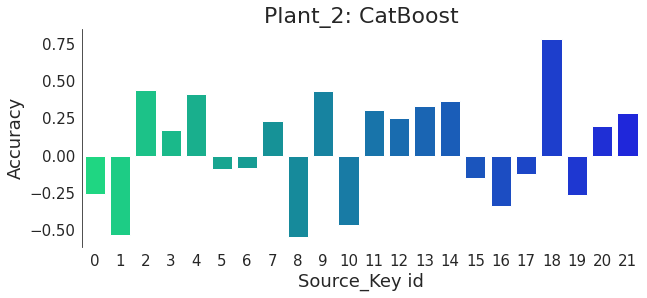

In [ ]:
fig = plt.figure(figsize=(10,4))

x = list(range(22))
y = cat_plant2_accuracy


sns.barplot(x,y, palette="winter_r")
sns.despine(bottom=True)

plt.title('Plant_2: CatBoost', fontsize = 22)
plt.xlabel('Source_Key id', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)

plt.show()

In [ ]:
cat_plant2_rmse = cat_results_plant2[1]
print(cat_plant2_rmse)

[2644.7165652921453, 2970.7972859452047, 1232.7531174892338, 2136.1383013639233, 1894.4627102367767, 2632.5746414679693, 2656.2760338161524, 1909.9062906449587, 2934.1804767383446, 1707.837113410896, 2620.986728907059, 1354.2036255349326, 1877.5583073160917, 1857.7783666432285, 1651.660918725556, 2603.41333789114, 2871.8300703158448, 2783.776731907393, 1025.999222796967, 2764.376337183507, 1947.0268272395183, 2091.4994157564847]


In [ ]:
#创建有规律可循的滞后变量名称
def build_df_name(source_key_list,name):
    createDataframe = locals()
    dataframeList = []
    for i in range(0,len(source_key_list)):
        createDataframe[name + str(i)] = 'lag{}' + name + str(i)
        dataframeList.append(createDataframe[name + str(i)])
    return dataframeList

In [ ]:
#构建带有滞后变量的表格
#exp_results必须为 纵向排列的连续型变量的解释结果(continuous_feature)
def improve_process(orig_dataset, exp_results, iterations):
    
    #lag_number = []
    #feature_name = []
    
    sum_values = float(exp_results.iloc[:,0].sum())  #解释结果的总和
    sort_exp_results = pd.DataFrame(exp_results[0].sort_values(ascending=False, inplace=False)) #按照解释值给特征排序（降序）
    
    for i in range(0, len(sort_exp_results)):
        
        feature_name = list(sort_exp_results.index)   #特征名称
        feature_values = float(sort_exp_results.iloc[i,0])  #特征的解释值
        number = int((feature_values/sum_values) * iterations)  #lag需要的滞后期数
        #lag_number.append(number)
                    
        if number <= 1:   
            break        #如果需要滞后的期数小于等于1，则停止程序（这也是为什么一定要对特征排序的原因）
        else:             #期数大于1的话，就可以开始创建滞后变量
            data_lag = pd.DataFrame(orig_dataset[feature_name[i]].copy())            #创建滞后变量的中间过渡表格
            data_lag.columns = [feature_name[i]]                                     #确保变量名称一致
            
            lag_name = build_df_name(list(sort_exp_results.index), 'feature')        #创建滞后变量的变量名字
            lag_feature_name = lag_name[i]                                           #按顺序选取变量名字
            
            for n in range(0, (number+1)):
                data_lag[lag_feature_name.format(n)] = data_lag[feature_name[i]].shift(n)         #滞后变量的表格
            
            data_lag_finish = data_lag.drop(columns = [feature_name[i]])                          #剔除原特征，避免最后合并的时候重复
        
            orig_dataset = pd.concat([orig_dataset,data_lag_finish],axis = 1)                      #合并表格
            orig_dataset = orig_dataset.dropna(axis = 0, how = 'any')                              #去除Nan值
            orig_dataset = orig_dataset.reset_index(drop=True)                                     #重置索引
        
    return orig_dataset

In [ ]:

def avg_lag(explained_dataset):
    l = len(explained_dataset.columns)
    list_ones = [1] * l
    data = pd.DataFrame(list_ones)
    data.index = explained_dataset.columns
    
    return data

def shap_results(model_name, explained_dataset):
    
    explainer = shap.TreeExplainer(model_name)
    shap_values = explainer(explained_dataset,check_additivity=False)
    
    shap_frame = pd.DataFrame(shap_values.values)
    df_global = pd.DataFrame()
    
    for i in range (0, len(shap_frame.columns)):
        shap_values_update = []
        each_shap_value = (abs(shap_frame[i]).sum())/len(shap_frame)
        
        shap_values_update.append(each_shap_value)
    
        df_global[i] = shap_values_update
        del shap_values_update
        
    df_global.columns = explained_dataset.columns
    df_global = df_global.T
        
    return df_global

def fi_results(model_name, explained_dataset):
    feature_importance = model_name.feature_importances_
    feature_importance = pd.DataFrame(feature_importance)
    feature_importance.index = explained_dataset.columns
    
    return feature_importance

def fi_shap_results(fi_all_result, shap_all_result):
    
    for n in range(0, len(fi_all_result[0])):
        
        weight_by_fi = (fi_all_result.iloc[n,0])/(fi_all_result[0].sum())
        shap_all_result.iloc[n,:] = shap_all_result.iloc[n,:] * weight_by_fi
        
    return shap_all_result

def shap_results_lgb(model_name, explained_dataset):
    
    explainer = shap.TreeExplainer(model_name)
    shap_values = explainer(explained_dataset)
    
    shap_frame = pd.DataFrame(shap_values.values)
    df_global = pd.DataFrame()
    
    for i in range (0, len(shap_frame.columns)):
        shap_values_update = []
        each_shap_value = (abs(shap_frame[i]).sum())/len(shap_frame)
        
        shap_values_update.append(each_shap_value)
    
        df_global[i] = shap_values_update
        del shap_values_update
        
    df_global.columns = explained_dataset.columns
    df_global = df_global.T
    return df_global

In [ ]:
len(df2)

22

In [ ]:
def improve_xgboost(orig_dataset, exp_results, iterations):
    
    acc = []
    rmse = [] 
    
    for i in range(1, iterations):
        improve_dataset = improve_process(orig_dataset, exp_results, i)
        
        train_set = improve_dataset[improve_dataset['DATE_TIME']<'2020-06-09 00:00']
        test_set = improve_dataset[improve_dataset['DATE_TIME']>='2020-06-09 00:00']

        x_train = train_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_train = train_set.loc[:,['DAILY_YIELD']]

        x_test=test_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_test=test_set.loc[:,['DAILY_YIELD']]
        
        model_xgb = XGBRegressor()

        model_xgb.fit(
                x_train, 
                y_train, 
                eval_metric="rmse", 
                eval_set=[(x_train, y_train),(x_test,y_test)], 
                verbose=False, 
                early_stopping_rounds = 100)
        
        prediction = model_xgb.predict(x_test)
        r2 = r2_score(y_test,prediction)
        RMSE = np.sqrt(mean_squared_error(y_test,prediction))
            
        acc.append(r2)
        rmse.append(RMSE)
    
    return acc, rmse 

In [ ]:
def improve_lightgbm(orig_dataset, exp_results, iterations):
    
    acc = []
    rmse = [] 
    
    for i in range(1, iterations):
        improve_dataset = improve_process(orig_dataset, exp_results, i)
        
        train_set = improve_dataset[improve_dataset['DATE_TIME']<'2020-06-09 00:00']
        test_set = improve_dataset[improve_dataset['DATE_TIME']>='2020-06-09 00:00']

        x_train = train_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_train = train_set.loc[:,['DAILY_YIELD']]

        x_test=test_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
        y_test=test_set.loc[:,['DAILY_YIELD']]

        model_lgb = lgb.LGBMRegressor()
        
        model_lgb.fit(x_train, y_train,eval_metric="rmse", 
                        eval_set=[(x_train, y_train)], 
                        verbose=False, 
                        early_stopping_rounds = 100)
        
        prediction = model_lgb.predict(x_test)
        r2 = r2_score(y_test,prediction)
        RMSE = np.sqrt(mean_squared_error(y_test,prediction))
            
        acc.append(r2)
        rmse.append(RMSE)
    
    return acc, rmse

In [ ]:
r2_xgb_avg = []
mse_xgb_avg = []



for i in range (0, len(df2)):
    df_plant_1 = df2[i]
    train_set = df_plant_1[df_plant_1['DATE_TIME']<'2020-06-09 00:00']
    test_set  = df_plant_1[df_plant_1['DATE_TIME']>='2020-06-09 00:00']
        
    x_train = train_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
    y_train = train_set.loc[:,['DAILY_YIELD']]
    x_test = test_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
    y_test = test_set.loc[:,['DAILY_YIELD']]

    avg_all = avg_lag(x_train)
    avg_results = avg_all.drop(index={'Year','Month','Day','Hour','Minute'},axis=0) #手动剔除离散变量



    results_by_avg = improve_lightgbm(df_plant_1, avg_results, 100)
    r2_avg = max(results_by_avg[0])
    r2_xgb_avg.append(r2_avg)

    mse_avg = min(results_by_avg[1])
    mse_xgb_avg.append(mse_avg)

In [ ]:
r2_xgb_avg

[-0.04230453793051936,
 -0.314132002956119,
 0.5760247819603272,
 0.6541916128028318,
 0.4050174686083209,
 0.0805131898566549,
 0.004588489214450653,
 0.3185434269528502,
 -0.5868065604416142,
 0.3984339216707876,
 0.19123111056962006,
 0.3271154337693578,
 0.11044944279425939,
 0.21371061660693325,
 0.4428504511542354,
 -0.051575276731076425,
 -0.21034000631592464,
 0.013843417442291894,
 0.7081627541005533,
 -0.28865129402558565,
 0.1934913212259235,
 0.25855897991168686]

In [ ]:
mse_xgb_avg

[2407.1717116833465,
 2746.316575860946,
 1071.027940092655,
 1381.0314912392712,
 1909.0015407174733,
 2416.1442835349144,
 2545.7613038021696,
 1799.7358642746797,
 2972.40291915022,
 1756.2832046433825,
 1946.6573501683965,
 1331.3437999115083,
 2045.9668848833244,
 2020.908688812873,
 1546.875854326182,
 2486.4385876060987,
 2726.379060880713,
 2609.306534687068,
 1194.1908410306435,
 2788.415105682431,
 1954.926039489824,
 2131.6655229161543]

In [ ]:
r2_results_shap = []
mse_results_shap = []



for i in range (0, len(df2)):
    df_plant_1 = df2[i]
    train_set = df_plant_1[df_plant_1['DATE_TIME']<'2020-06-09 00:00']
    test_set  = df_plant_1[df_plant_1['DATE_TIME']>='2020-06-09 00:00']
        
    x_train = train_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
    y_train = train_set.loc[:,['DAILY_YIELD']]
    x_test = test_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
    y_test = test_set.loc[:,['DAILY_YIELD']]

    model_lgb = lgb.LGBMRegressor()
        
    model_lgb.fit(x_train, y_train,eval_metric="rmse", 
                        eval_set=[(x_train, y_train)], 
                        verbose=False, 
                        early_stopping_rounds = 100)
    
    shap_all = shap_results_lgb(model_lgb, x_train)
    shapdf_results = shap_all.drop(index={'Year','Month','Day','Hour','Minute'},axis=0) #手动剔除离散变量


    results_by_shap = improve_lightgbm(df_plant_1, shapdf_results, 100)
    r2_shap = max(results_by_shap[0])
    mse_shap = min(results_by_shap[1])
    r2_results_shap.append(r2_shap)
    mse_results_shap.append(mse_shap)


In [ ]:
r2_results_shap

[0.248032387873366,
 0.20667128986621042,
 0.5979700370010101,
 0.7706607364849121,
 0.9030468043916441,
 0.04753608802257692,
 0.02221182297781843,
 0.3246084473708498,
 -0.00883132578687329,
 0.3097195628074225,
 0.6152941086794272,
 0.30701997854568175,
 0.10781628254209208,
 0.5035537154247239,
 0.4773048989671034,
 0.0006355360653171882,
 0.026920483908105086,
 0.19042545240935982,
 0.9018931715438055,
 -0.29018066601203074,
 0.22490851672227108,
 0.3137567363678896]

In [ ]:
mse_results_shap

[2044.6045577247542,
 2133.8195411816755,
 1042.941083159373,
 1124.6697840807763,
 770.6110557508991,
 2459.08974207237,
 2523.124858357362,
 1791.7090648055453,
 2370.0361216286574,
 1881.332948374149,
 1342.5847624936077,
 1351.0775996553505,
 2048.992782479624,
 1605.8006065285726,
 1498.2827647862043,
 2423.926824311819,
 2444.593814718131,
 2364.1802546416084,
 692.3935205169768,
 2790.069261245873,
 1916.4711737806804,
 2050.783447318571]

In [ ]:
r2_results_fi = []
mse_results_fi = []



for i in range (0, len(df2)):
    df_plant_1 = df2[i]
    train_set = df_plant_1[df_plant_1['DATE_TIME']<'2020-06-09 00:00']
    test_set  = df_plant_1[df_plant_1['DATE_TIME']>='2020-06-09 00:00']
        
    x_train = train_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
    y_train = train_set.loc[:,['DAILY_YIELD']]
    x_test = test_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
    y_test = test_set.loc[:,['DAILY_YIELD']]


    model_lgb = lgb.LGBMRegressor()
        
    model_lgb.fit(x_train, y_train,eval_metric="rmse", 
                        eval_set=[(x_train, y_train)], 
                        verbose=False, 
                        early_stopping_rounds = 100)
    
    fi_all = fi_results(model_lgb, x_train)
    fi = fi_all.drop(index={'Year','Month','Day','Hour','Minute'},axis=0) #手动剔除离散变量

    results_by_fi = improve_lightgbm(df_plant_1, fi, 100)
    r2_fi = max(results_by_fi[0])
    mse_fi = min(results_by_fi[1])
    r2_results_fi.append(r2_fi)
    mse_results_fi.append(mse_fi)

In [ ]:
r2_results_fi

[0.27882104907604455,
 -0.061315059486548806,
 0.5707057795710194,
 0.7144741962629534,
 0.8845937308138249,
 0.20560460794518753,
 0.1695797013261059,
 0.39648223831860174,
 -0.17951335924835066,
 0.3675250127513938,
 0.5008587394403681,
 0.31717369220094915,
 0.16810506642562928,
 0.17799746144036965,
 0.4291378525375744,
 0.1274406867882374,
 0.01208792886531318,
 0.16255333316450926,
 0.7292030243247576,
 -0.2247314474699027,
 0.17775950035652632,
 0.325519805434604]

In [ ]:
mse_results_fi

[2002.3098233333722,
 2468.046089270364,
 1077.7253173973045,
 1254.898216125276,
 840.753864333264,
 2245.7865242440243,
 2325.2268529435905,
 1693.6930550145328,
 2562.696156384175,
 1800.8376266832277,
 1529.2871210127596,
 1341.1429134117664,
 1978.552241331565,
 2066.2937620995654,
 1565.7960470733624,
 2264.9312960028565,
 2463.154702916484,
 2404.5330019820835,
 1150.3375109281008,
 2718.3799253510365,
 1973.90042690262,
 2033.130975513406]

In [ ]:
r2_results_fi_shap = []
mse_results_fi_shap = []



for i in range (0, len(df2)):
    df_plant_1 = df2[i]
    train_set = df_plant_1[df_plant_1['DATE_TIME']<'2020-06-09 00:00']
    test_set  = df_plant_1[df_plant_1['DATE_TIME']>='2020-06-09 00:00']
        
    x_train = train_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
    y_train = train_set.loc[:,['DAILY_YIELD']]
    x_test = test_set.drop(columns={'DATE_TIME','DAILY_YIELD','TOTAL_YIELD'},axis=1)
    y_test = test_set.loc[:,['DAILY_YIELD']]

    model_lgb = lgb.LGBMRegressor()
        
    model_lgb.fit(x_train, y_train,eval_metric="rmse", 
                        eval_set=[(x_train, y_train)], 
                        verbose=False, 
                        early_stopping_rounds = 100)
        
    prediction = model_lgb.predict(x_test)
    r2 = r2_score(y_test,prediction)
    RMSE = np.sqrt(mean_squared_error(y_test,prediction))
    
    shap_all = shap_results_lgb(model_lgb, x_train)

    fi_all = fi_results(model_lgb, x_train)
    
    fi_shap_all = fi_shap_results(fi_all,shap_all)
    fi_shap = fi_shap_all.drop(index={'Year','Month','Day','Hour','Minute'},axis=0) #手动剔除离散变量 

    results_by_fi_shap = improve_lightgbm(df_plant_1, fi_shap, 100)
    r2_fi_shap = max(results_by_fi_shap[0])
    mse_fi_shap = min(results_by_fi_shap[1])

    r2_results_fi_shap.append(r2_fi_shap)
    mse_results_fi_shap.append(mse_fi_shap)

In [ ]:
r2_results_fi_shap

[0.2530037914311255,
 0.07457778021249961,
 0.5856076668659952,
 0.6880980460822501,
 0.8894458309211014,
 0.13522346953415576,
 0.11744402746658256,
 0.3560885663661367,
 0.02297671105918675,
 0.3248300089466427,
 0.6705698296466582,
 0.29077366525608983,
 0.18830312821263806,
 0.4034828550102805,
 0.47598585059916365,
 0.14294962308358117,
 -0.025441843084225146,
 0.16163768024886194,
 0.8840535494481956,
 -0.22240971416075395,
 0.18850473619592156,
 0.345788464690327]

In [ ]:
mse_results_fi_shap

[2037.8347115689905,
 2304.629218938407,
 1058.8548257469313,
 1311.5802497587315,
 822.8899035023746,
 2343.160624560734,
 2397.1073342730024,
 1749.454883782264,
 2332.3737419639724,
 1860.6275377618895,
 1242.3929570992532,
 1366.8232674615142,
 1954.3854386672153,
 1760.219997174855,
 1500.1720709741733,
 2244.7125192094177,
 2509.504973572262,
 2405.847184865533,
 752.7176610051569,
 2715.80207565509,
 1960.960309896603,
 2002.3493678846837]